# Variational Inference using VAEs and Normalizing Flows

## Setting the Scene

In this assignment, we implement a vanilla VAE from scratch and train it on grayscale images of the MNIST handwritten digits dataset.
Then, we train the same model but use a Normalizing Flow as variational distribution to approximate the true posterior.

For the (vanilla) VAE:

- Suggest one final version that uses dense-layers only *or* convolution/de-convolution.
- Assume a standard normal prior belief.
- Use a diagonal Gaussion as variational distribution.
- As reconstruction loss, choose between MSE and BCE.
- If necessary, implement it as a $\beta$-VAE that allows you to put an (adaptive) weight on the KL-divergence.

Much like the previous assignment, you shall fill out the blanks, answer the questions, and evaluate and compare your trained models.
However, we will not be implementing Normalizing Flows, due to the complexity of bijectors, conditioners, and other required coupling blocks.
Instead, you shall use a library/framework.

Suggested are these 2:

- PyTorch: Use the `normflows` package: <https://github.com/VincentStimper/normalizing-flows> (preferred)
- JAX: Use the `pzflow` package: <https://github.com/jfcrenshaw/pzflow>

It is acceptable to use something else, but make sure you can integrate it nicely into your VAE implementation.
As for the NF model itself:

- Use a diagonal Gaussian base distribution 
- Try to keep the model relatively shallow (less than ca. ten blocks)
- Attempt to use as few as possible parameters in the conditioners


# Part 1: Implement your own VAE

## Recap: Variational Bayes

In our first lecture and assignment, we took a Bayesian variational approach to **quantify uncertainty** in our model's parameters.
Let's call this **Scenario A**.

In **A**,
- we have a polynomial with a handful of parameters.
- Our prior belief over these parameters $p(\mathbf{w})=\mathcal{N}(0,I)$.
- The true posterior, $p(\mathbf{w}\vert\mathbf{X},\mathbf{y})$, is approximated using a mean-field variational distribution. Our choise was a diagonal Gaussian: $q_{\phi}(\mathbf{w})=\mathcal{N}(\mu_{\phi},\Sigma_{\phi})$.
- The ELBO was: $\text{ELBO}=\mathbb{E}_{q_{\phi}(\mathbf{w})}\left[\log{(p(\mathbf{y}|\mathbf{X},\mathbf{w}))}\right]-D_{\text{KL}}\left(q_{\phi}(\mathbf{w})\|p(\mathbf{w})\right)$.
- The Monte Carlo approximation of the ELBO is: $\text{ELBO}(\phi)\approx\frac{1}{S}\sum_{s=1}^{S}\,\underbrace{\left[\sum_{i=1}^{N}\,\log{(p(y_i|x_i,w^{(s)}))}\right]}_{\text{log-sum of i.i.d. observations}}-\underbrace{\left[\log{\left(q_{\mu,\sigma}\left(w^{(s)}\right)\right)}-\log{\left(p\left(w^{(s)}\right)\right)}\right]}_{\text{MC-approx. of KL-divergence}}$.


So, in order to introduce variation, we insert randomness into our model using the reparameterization trick.
Since we optimize the current $\mu,\sigma$ of our variational distribution, it needs to be differentiable w.r.t. those parameters.
Recall that $w=\mu+\sigma\cdot\epsilon$.
So, in order to average the effect of many different $w^{(s)}\in W$, we compute the mean of our model's predictions using these varying parameters.
Then, we maximize the average ELBO.

## Differences in a Variational Autoencoder

Now, in a vanilla variational autoencoder (VAE), we **quantify uncertainty in the latent variables, per individial observation**.
Here, we will make use of so-called **amortized inference**.

A VAE has these components:
- An **Encoder** Network.
    * Takes the input data and predicts, for **each** observation $x_i\in\mathbf{X}$, the parameters of our approximate posterior $q_{\phi}(\mathbf{Z}|\mathbf{X})=\mathcal{N}(\mathbf{Z}, \mathbf{\mu}_{\phi}(\mathbf{X}),\Sigma_{\phi}(\mathbf{X}))$.
    * The conditional prediction (per observation) of the variational parameters is called amortized inference.
    * If our latent dimension is 20, for example, then we would need to predict 20 means and 20 variances, per observation.
    * The reparameterization trick lies in constructing $z=\mu+\sigma\cdot\epsilon$ for an epsilon drawn from a standard normal. Then, it is this $z$ that gets decoded.
- A set of latent variables (denoted $\mathbf{Z}$). Usually the dimensionality of $\mathbf{Z}$ is lower than that of the input, $X$.
- A **Decoder** Network.
    * Given $\mathbf{Z}$, learns to predict a reconstructed $\mathbf{X}'\approx\mathbf{X}$.

<pre>
Input X --> Encoder Network (phi)  --> Latent variables Z ~ q_{phi}(Z|X) -->
    Decoder Network (theta)  -->  Reconstructed X (X').
</pre>

Notice how our **prior** belief relates now to hoe each $z_i$ is distributed.
Again, here we will assume $p(\mathbf{Z})\sim\mathcal{N}(0,I)$.
During training, we will minimize again the Kullback-Leibler divergence between this prior belief and our mean-field approximation:

$$
\begin{align}
    D_{\text{KL}}(q_{\phi}(z|x))\,\|\,p(z)
\end{align}
$$

for **each** observation $x$.
If we now add a reconstruction term, it will constitute the ELBO loss.
Since each observation constitutes itw own Gaussian in latent space, $q_{\phi}(z|x)$ differs for each x.
Therefore, only the **aggregate** distribution $q_{\phi}(z)$ matches the prior.
The encoder network naturally shares (has the same set of) parameters across all observations, making it generalize to the dataset.

## Implementation

The following is a skeleton for a PyTorch-based implementation.

You may or may not follow this skeleton, it is just a suggestion.

Choose one architecture that works best for you (dense *or* convolutional).

In [27]:
import torch
from torch import nn, Tensor
from torch.distributions.normal import Normal


class MyVAE(nn.Module):
    """
    A vanilla VAE with standard normal prior belief and normal independent variational
    distribution. Has a configurable latent size.
    """

    def __init__(self, dim: int, dim_z: int=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # TODO: A VAE has en encoder and a decoder that you can define here as modules.
        # encoder: dim → 400 → (μ, logvar)
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(dim, 400),
            nn.ReLU(inplace=True),
        )
        self.fc_mu     = nn.Linear(400, dim_z)
        self.fc_logvar = nn.Linear(400, dim_z)

        # decoder: dim_z → 400 → dim
        self.decoder = nn.Sequential(
            nn.Linear(dim_z, 400),
            nn.ReLU(inplace=True),
            nn.Linear(400, dim),
            nn.Sigmoid(),  # for BCE reconstruction
        )
    

    def encode(self, x: Tensor) -> tuple[Tensor, Tensor]:
        """Encodes the input and returns the mus and variances."""
        # TODO: This is the amortized-inference part, where you predict means and
        # TODO: (log-)variances, one for each observation in x.
        h = self.encoder(x.view(x.size(0), -1))
        mu     = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
        
    def forward(self, x: Tensor) -> tuple[Tensor, Tensor]:
        """
        Takes the original input, encodes it, applies the R-trick,
        reconstructs the inputs, and calculates the KL-divergence.
        Returns the reconstruction and the divergence.
        """
        # flatten if needed
        x_in = x.view(x.size(0), -1)
        mu, logvar = self.encode(x_in)
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        z = mu + std * eps

        out = self.decoder(z)
        recon = out.view_as(x)

        # KL divergence per sample
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

        return recon, kl
    
    def sample(self, n: int) -> Tensor:
        """Sample from the trained model using the unconditional prior."""
        device = next(self.parameters()).device
        z = torch.randn(n, self.fc_mu.out_features, device=device)
        out = self.decoder(z)
        # return flat vectors; reshape as needed externally
        return out

# Part 2: Enhance VAE with a Normalizing Flow

When we change our the variational distribution of a VAE to be a Normalizing Flow, we still use the same ELBO.
But things change a little, because we kind of use the flow "backwards":

1. The encoder, as before, outputs variational parameters $\mu$ and $\sigma$, conditioned (*amortized*) on the input $x$.
2. We will assume a normal isotropic Gaussian as the NF's base distribution.
    * However, instead of parameterizing it directly and sampling from it, we have to apply the reparameterization trick.
    * It is simpler to just sample from a standard normal isotropic Gaussian and construct $z_0=\mu+\sigma\cdot\epsilon$.
3. $z_0$ enters the flow.
    * Through a series of $K$ transformations, it becomes $z_K=T_K\circ T_{K-1}\circ\dots\circ T_1(z_0)$.
    * The variational distribution is now $q_{\phi}(z_K\vert x)$.
4. $z_K$ is now fed into the decoder, that is, $x'\sim p_{\theta}(x\vert z_K)$, which shall reconstruct the original inputs $x$.


----

Since we assume a diagonal normal as base distribution for our normalizing flow here ($\psi$), the change-of-variables formula is defined as:

$$
\begin{align}
    q_{\phi}(z_K\vert x)=\psi_{\phi}(z_0)\,\left\lvert\operatorname{det}\frac{\partial\,z_0}{\partial\,z_K}\right\rvert=\psi_{\phi}(z_0)\prod_{k=1}^{K}\,\left\lvert\operatorname{det}\frac{\partial\,z_{k-1}}{\partial\,z_k}\right\rvert.
\end{align}
$$

----

## Define the Flow Model

Below is some boilerplate code for constructing a Normalizing Flow using the `normflows` package.
Even if you choose something else, perhaps you want to conceptually construct your flow similar to how it's done here.

In [ ]:
from normflows import NormalizingFlow
from normflows.flows import Flow, AutoregressiveRationalQuadraticSpline, LULinearPermute
# from typing import override


def make_flows(dim: int, K: int, units: int=128, layers: int=2) -> list[Flow]:
    """Repeats a sequence of pre-defined coupling blocks K times."""
    flows: list[Flow] = []
    for _ in range(K):
        flows.append(AutoregressiveRationalQuadraticSpline(
            num_input_channels=dim, num_blocks=layers, num_hidden_channels=units))
        flows.append(LULinearPermute(num_channels=dim))
    return flows



class MyVAEwithNF(MyVAE):
    # override
    def __init__(self, K: int, dim: int, dim_z: int=10, *args, **kwargs):
        super().__init__(dim=dim, dim_z=dim_z, *args, **kwargs)
        
        flows = make_flows(dim_z, K)

        # TODO: Add flow as a module.
        self.flow = NormalizingFlow(q0=None, flows=flows, p=None)
        ...
    

    # override
    def sample(self, n: int) -> Tensor:
        """Draw unconditional samples (z_0), pass them through the flow (z_K), then decode."""
        device = next(self.parameters()).device
        # base samples
        z0 = torch.randn(n, self.fc_mu.out_features, device=device)
        # push through flow
        zK, _ = self.flow(z0)
        out = self.decoder(zK)
        return out
    

    # override
    def forward(self, x: Tensor) -> tuple[Tensor, Tensor]:
        """Returns the reconstruction and KL-divergence."""
        x_in = x.view(x.size(0), -1)
        mu, logvar = self.encode(x_in)
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        z0 = mu + std * eps

        # flow transform
        zK, sum_log_abs_det = self.flow(z0)

        # recon
        out = self.decoder(zK)
        recon = out.view_as(x)

        # log q₀(z₀|x)
        q0 = Normal(mu, std)
        log_q0 = q0.log_prob(z0).sum(dim=1)
        # log p(z_K) under N(0,I)
        pz = Normal(torch.zeros_like(zK), torch.ones_like(zK))
        log_pz = pz.log_prob(zK).sum(dim=1)

        # change-of-vars: log q(zK|x) = log q0(z0|x) - ∑ log|det J|
        log_qzK = log_q0 - sum_log_abs_det

        # KL = E[log q(zK|x) - log p(zK)]
        kl = log_qzK - log_pz

        return recon, kl

# Training

We will train on grayscale MNIST handwritten digits.
The goal is to train either architecture and then to compare the results.

## Download and Prepare the Data

In [29]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

batch_size = 192

transform = transforms.Compose([ transforms.ToTensor() ])

# Download and load MNIST training set
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)

# Load MNIST test set
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, drop_last=True, shuffle=False)

In [30]:
train_dataset.data.shape, test_dataset.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

## Using ELBO

Recall that the ELBO is essentially the expectation of the log-likelihood of the data under our currently parameterized model minus the KL-divergence of the variational distribution and the prior belief.

Recall that the (log-)likelihood function does not have to be a proper probability density.
Instead, it should yield values that allow relative comparisons on how well the certain parameters represent our data.
Here, $f_{\theta}$ represents our decoder that reconstructs the inputs, i.e., $f\mapsto X'$.

$$
\begin{align}
    \text{ELBO}(\theta,\phi;x)=\mathbb{E}_{q_{\phi}(z|x)}\left[-\text{reconstruction loss}\left(x,f_{\theta}(z)\right)\right]-D_{\text{KL}}\left(q_{\phi}(z|x)\,\|\,p(z)\right)\nonumber.
\end{align}
$$


In a VAE, we typically have a reconstruction loss like MSE.
We can just plug it into the expectation and use it as our likelihood.
Then, we negate the ELBO to obtain our loss objective $\mathcal{J}$ for minimization:

$$
\begin{align}
    \operatorname{MSE}\left(x,\mu_{\theta}(z)\right)&=\left\|x-\mu_{\theta}(z)\right\|^2,\nonumber
    \\[1em]
    \mathcal{J}(\theta,\phi;x)&=\underbrace{\mathbb{E}_{q_{\phi}(z|x)}\left[\left\|x-\mu_{\theta}(z)\right\|^2\right]}_{\text{expected (mean) reconstr. error}} + D_{\text{KL}}\left(q_{\phi}(z|x)\,\|\,p(z)\right)\nonumber.
\end{align}
$$

## The Vanilla VAE

Let's train this model first.
It is perhaps easiest to use the same training routine for either model (with/without NF).

In [31]:
import numpy as np
from torch import device
from torch.optim import Adam

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib import animation

if torch.cuda.is_available():
    print("Using GPU")


DEVICE = device("cuda" if torch.cuda.is_available() else "cpu") # i used this from the project
DIM_Z = 12
LEARNING_RATE = 0.001
EPOCHS = 10
KL_DIV_BETA = 1.0 # Only used if you implemented a beta-VAE

# For MNIST digits, this is 768
model = MyVAE(dim=np.prod(train_dataset.data.shape[1:]).item(), dim_z=DIM_Z).to(device=DEVICE)
optim = Adam(params=model.parameters(), lr=LEARNING_RATE)

# TODO: Fill in the blanks and stick with the best-working configuration in your case.

### Evaluation

Please provide **4** kinds of plots now:

1. Training progress. Show the reconstruction loss and KL-divergence separately.
2. "Animation" of the latent space. For example, draw a sample from your prior belief and gradually manipulate it along a single dimension (keep others constant) to demonstrate what this dimensions has effectively learned.
3. Draw at least 25 random samples using your prior belief from the trained model.
4. Use the trained model to encode all the images from the holdout dataset. Further reduce the dimensionality to 2 using TSNE and plot the results


In [32]:
# --- Training loop with tracking ---
train_recon_losses = []
train_kls = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_recon = 0.0
    total_kl = 0.0
    total_n = 0

    for x, _ in train_loader:
        x = x.to(DEVICE)
        optim.zero_grad()

        recon, kl = model(x)
        # reconstruction loss (MSE)
        recon_loss = ((x - recon)**2).view(x.size(0), -1).sum(dim=1).mean()
        kl_mean    = kl.mean()

        loss = recon_loss + KL_DIV_BETA * kl_mean
        loss.backward()
        optim.step()

        bs = x.size(0)
        total_recon += recon_loss.item() * bs
        total_kl    += kl.sum().item()
        total_n     += bs

    epoch_recon = total_recon / total_n
    epoch_kl    = total_kl    / total_n

    train_recon_losses.append(epoch_recon)
    train_kls.append(epoch_kl)

    print(f"Epoch {epoch}/{EPOCHS} — Recon Loss: {epoch_recon:.4f}, KL: {epoch_kl:.4f}")

Epoch 1/10 — Recon Loss: 42.9136, KL: 5.3100
Epoch 2/10 — Recon Loss: 25.8578, KL: 9.4301
Epoch 3/10 — Recon Loss: 22.9195, KL: 10.4054
Epoch 4/10 — Recon Loss: 21.6690, KL: 10.7813
Epoch 5/10 — Recon Loss: 20.9071, KL: 11.0422
Epoch 6/10 — Recon Loss: 20.3622, KL: 11.2069
Epoch 7/10 — Recon Loss: 19.9688, KL: 11.3269
Epoch 8/10 — Recon Loss: 19.6173, KL: 11.4656
Epoch 9/10 — Recon Loss: 19.3747, KL: 11.5551
Epoch 10/10 — Recon Loss: 19.1104, KL: 11.6281


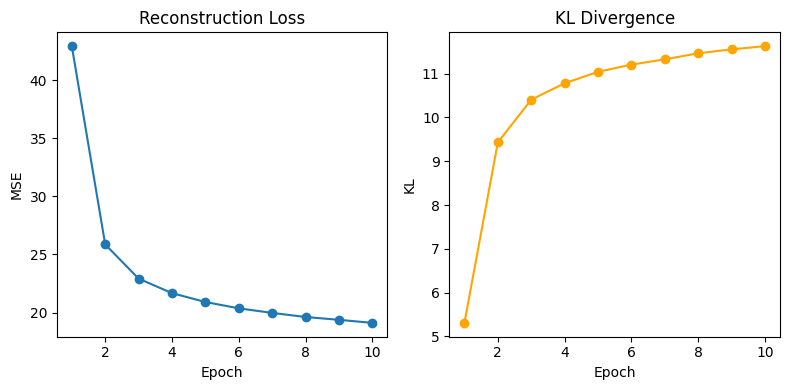

C:\Users\kemal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


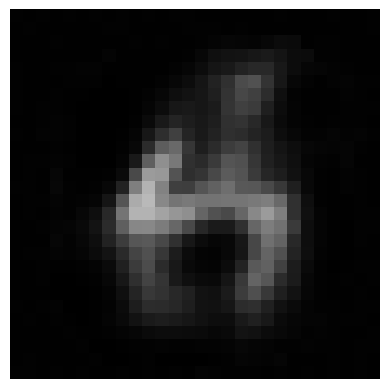

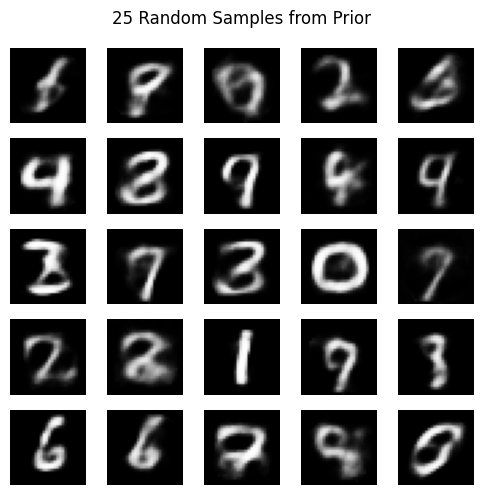

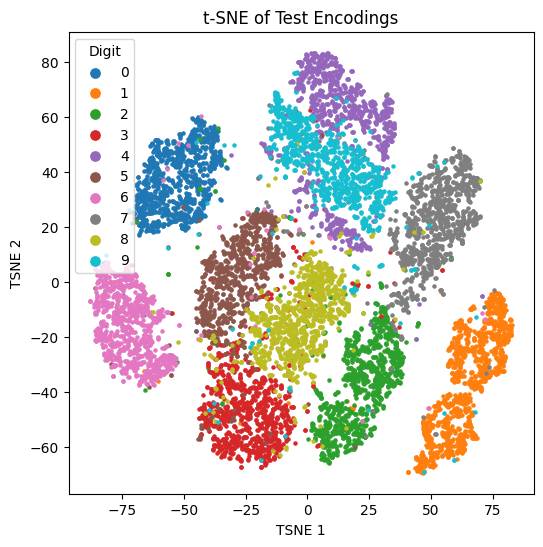

In [33]:
# --- 1) Plot training progress ---
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(range(1, EPOCHS+1), train_recon_losses, marker='o')
plt.title("Reconstruction Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")

plt.subplot(1,2,2)
plt.plot(range(1, EPOCHS+1), train_kls, marker='o', color='orange')
plt.title("KL Divergence")
plt.xlabel("Epoch")
plt.ylabel("KL")
plt.tight_layout()
plt.show()

# --- 2) Animation of latent dimension ---
# pick a base latent vector (zeros)
z_base = torch.zeros(1, DIM_Z, device=DEVICE)
# vary dimension 0 from -3 to +3
zs = []
for alpha in np.linspace(-3, +3, 60):
    z = z_base.clone()
    z[0, 0] = alpha
    zs.append(z)
zs = torch.cat(zs, dim=0)
with torch.no_grad():
    imgs = model.decoder(zs).cpu().view(-1, 1, 28, 28).numpy()

fig = plt.figure()
im = plt.imshow(imgs[0,0], cmap='gray', vmin=0, vmax=1)
plt.axis('off')

def update(frame):
    im.set_data(imgs[frame,0])
    return (im,)

anim = animation.FuncAnimation(fig, update, frames=len(imgs), interval=100)
plt.show()

# --- 3) 25 random samples from prior ---
with torch.no_grad():
    z_rand = torch.randn(25, DIM_Z, device=DEVICE)
    samples = model.decoder(z_rand).cpu().view(-1, 1, 28, 28).numpy()

plt.figure(figsize=(5,5))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(samples[i,0], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
plt.suptitle("25 Random Samples from Prior")
plt.tight_layout()
plt.show()

# --- 4) TSNE on encoded test set ---
model.eval()
all_mu = []
all_labels = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        mu, _ = model.encode(x.view(x.size(0), -1))
        all_mu.append(mu.cpu().numpy())
        all_labels.append(y.numpy())
all_mu = np.concatenate(all_mu, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# reduce to 2D
tsne = TSNE(n_components=2, random_state=42)
mu_2d = tsne.fit_transform(all_mu)

plt.figure(figsize=(6,6))
for digit in range(10):
    idx = all_labels == digit
    plt.scatter(mu_2d[idx,0], mu_2d[idx,1], label=str(digit), s=5)
plt.legend(markerscale=3, title="Digit")
plt.title("t-SNE of Test Encodings")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.show()

**Question**: For the first plot: What did any of the latent dimensions learned? What happens when you animate a single dimension between, say, `[-3,3]`?

**Question**: What is your qualitative evaluation of the samples from the 2nd plot?

**Question**: What is your interpretation of the 3rd plot? Has the model learned something useful?

## The NF-backed VAE

The ELBO stays the exact same.
However, we have to plug in our more flexible variational distribution (which is calculated using the NF's chosen base-distribution and the determinant of the transformation).

Recall that ($z_0$ being the output of the encoder):

$$
\begin{align}
    q_{\phi}(z_K\vert x)&=\psi_{\phi}(z_0)\,\left\lvert\operatorname{det}\frac{\partial\,z_0}{\partial\,z_K}\right\rvert=\psi_{\phi}(z_0)\prod_{k=1}^{K}\,\left\lvert\operatorname{det}\frac{\partial\,z_{k-1}}{\partial\,z_k}\right\rvert.
    \\[1em]
    \log{\left(q_{\phi}(z_K\vert x)\right)}&=\log{\left(\psi_{\phi}(z_0)\right)} + \underbrace{\log{\left(\left\lvert\operatorname{det}\frac{\partial\,z_0}{\partial\,z_K}\right\rvert\right)}}_{\text{the "logabsdet"}}=\log{\left(\psi_{\phi}(z_0)\right)}+\sum_{k=1}^{K}\,\log{\left(\left\lvert\operatorname{det}\frac{\partial\,z_{k-1}}{\partial\,z_k}\right\rvert\right)}.

\end{align}
$$


$$
\begin{align}
    \text{ELBO}(\theta,\phi;x)&=\mathbb{E}_{q_{\phi}(z_K\vert x)}\left[\log{\left(p_{\theta}(z_K\vert x)\right)}\right]-D_{\text{KL}}\left[q_{\phi}(z\vert x)\,\|\,p(z)\right],
    \\[1em]
    &=\mathbb{E}_{q_{\phi}(z_K\vert x)}\left[\log{\left(p_{\theta}(z_K\vert x)\right)}\right]-\mathbb{E}_{q_{\phi}(z_K\vert x)}\left[\log{\left(\frac{q_{\phi}(z_K\vert x)}{p(z_K)}\right)}\right],
    \\[1em]
    &=\mathbb{E}_{q_{\phi}(z_K\vert x)}\left[\log{\left(p_{\theta}(z_K\vert x)\right)}\right]-\mathbb{E}_{q_{\phi}(z_K\vert x)}\left[\underbrace{\log{\left(\psi_{\phi}(z_0)\right)-\sum_{k=1}^{K}\,\log{\left\lvert\operatorname{det}\frac{\partial\,z_k}{\partial\,z_{k-1}}\right\rvert}}}_{q_{\phi}(z_K\vert x)}-\log{\left(p(z_K)\right)}\right],
    \\[3em]
    \text{Notice that}&\text{ numerator and denominator in the determinant (and its sign) have flipped! (see below)}\nonumber
    \\[1em]
    &=\mathbb{E}_{q_{\phi}(z_K\vert x)}\left[\log{\left(p_{\theta}(z_K\vert x)\right)}-\log{\left(\psi_{\phi}(z_0)\right)+\sum_{k=1}^{K}\,\log{\left\lvert\operatorname{det}\frac{\partial\,z_k}{\partial\,z_{k-1}}\right\rvert}}+\log{\left(p(z_K)\right)}\right]
    \\[2em]
    \text{Notice that}&\text{ the Monte Carlo approximation for $l$ samples becomes:}\nonumber
    \\[1em]
    &\approx\frac{1}{L}\sum_{l=1}^{L}\,\left(-\mathcal{R}\left(x,z_K^{(l)};\theta\right)\right)-\log{\left(\psi_{\phi}\left(z_0^{(l)}\right)\right)+\sum_{k=1}^{K}\,\log{\left\lvert\operatorname{det}\frac{\partial\,z_k^{(l)}}{\partial\,z_{k-1}^{(l)}}\right\rvert}}+\log{\left(p\left(z_K^{(l)}\right)\right)}.
    \\[2em]
    \text{Notice that}&\text{ $\mathcal{R}$ is the reconstruction loss.}\nonumber
\end{align}
$$

The fraction of computing the determinant flips according to the logarithm laws (determinants satisfy precisely the reciprocal relationship $\operatorname{det}(\frac{a}{b})=\left(\operatorname{det}\frac{b}{a}\right)^{-1}$).

Therefore, we have $\log{\left\lvert\operatorname{det}(a/b)\right\rvert}=-\log{\left\lvert\operatorname{det}(b/a)\right\rvert}$.
We have to flip it because usually we would transform $z_0$ to $z_K$, giving us the determinant for that transformation.
However, to evaluate the log-likelihood of $z_0$, we require the determinant from the inverse transformation!
Therefore, we have to subtract its reciprocal instead.

The NF-backed VAE in a nutshell:

- $x\mapsto z_0$
    * Use the encoder and reparameterization trick to produce $z_0$.
- $z_0\mapsto z_K$
    * For a discrete normalizing flow with $K$ transformations.
- $z_K\mapsto\approx x$
    * Use the decoder to reconstruct the original $x\approx x'$.

### Training

Here, train your NF-backed VAE with the optimal parameters found by you.

In order to get comparable results, do **not** alter the number of latent dimensions.

### Evaluation

Conduct the exact same evaluation as you did for the vanilla VAE.
Produce the same kind of plots and answer the same questions **again**!

**Another Question**: Which model is better? How did you measure this and come to that conclusion?

In [67]:


import torch
from torch import nn, Tensor
from torch.distributions import Normal
from torch.optim import Adam
import numpy as np

DEVICE = device("cuda" if torch.cuda.is_available() else "cpu") # i used this from the project
print("Using device:", DEVICE)

class MyVAEwithNF(MyVAE):
    # override
    def __init__(self, K: int, dim: int, dim_z: int=10, *args, **kwargs):
        super().__init__(dim=dim, dim_z=dim_z, *args, **kwargs)
        flows = make_flows(dim_z, K)
        self.flow = NormalizingFlow(q0=None, flows=flows, p=None)

    # override
    def forward(self, x: Tensor) -> tuple[Tensor, Tensor]:
        x_in = x.view(x.size(0), -1)
        mu, logvar = self.encode(x_in)
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        z0 = mu + std * eps

        # forward flow outputs (z_K, forward_logabsdets_per_block)
        #zK, forward_logabsdets = self.flow(z0)
        # sum across all blocks to get a single per-sample forward log|det|

                # grab only first two outputs: z_K and per-block forward log|det|
        flow_out = self.flow(z0)
        zK               = flow_out[0]
        forward_logabsdets = flow_out[1]

        forward_logabsdet = forward_logabsdets.sum(dim=-1)

        out   = self.decoder(zK)
        recon = out.view(-1, 1, 28, 28)

        q0     = Normal(mu, std)
        log_q0 = q0.log_prob(z0).sum(dim=-1)
        pz     = Normal(torch.zeros_like(zK), torch.ones_like(zK))
        log_pz = pz.log_prob(zK).sum(dim=-1)

        # **FIXED**: add forward_logabsdet (inverse Jacobian) instead of subtracting
        #log_qzK = log_q0 + forward_logabsdet
        log_qzK = log_q0 + forward_logabsdet
        kl      = log_qzK - log_pz

        return recon, kl

    # override
    def sample(self, n: int) -> Tensor:
        device = next(self.parameters()).device
        z0 = torch.randn(n, self.fc_mu.out_features, device=device)
        zK, _ = self.flow(z0)
        return self.decoder(zK)
    
    


LEARNING_RATE = 0.001
EPOCHS = 10
KL_DIV_BETA = 1.5

# For MNIST digits, this is 768
model = MyVAEwithNF(K=10, dim=np.prod(train_dataset.data.shape[1:]).item(), dim_z=DIM_Z).to(device=DEVICE)



optim = Adam(params=model.parameters(), lr=LEARNING_RATE)

train_recon_losses = []
train_kls = []



# ---- DEBUG on first batch ----
x_debug, _ = next(iter(train_loader))
x_debug = x_debug.to(DEVICE)

with torch.no_grad():
    recon_d, kl_d = model(x_debug)
    print("  recon shape:", recon_d.shape)
    print("  kl shape:   ", kl_d.shape)
    print("  kl  first5: ", kl_d[:5].cpu().numpy())
    # and break—don’t wait for an epoch!
print(">>>> DEBUG DONE <<<<\n")




# --- Training loop ---



for epoch in range(1, EPOCHS + 1):
    model.train()
    total_recon = 0.0
    total_kl = 0.0
    total_n = 0

    for x, _ in train_loader:
        x = x.to(DEVICE)
        optim.zero_grad()

        recon, kl = model(x)
        # reconstruction loss (MSE)
        recon_loss = ((x - recon) ** 2).view(x.size(0), -1).sum(dim=1).mean()
        kl_mean    = kl.mean()

        loss = recon_loss + KL_DIV_BETA * kl_mean
        loss.backward()
        optim.step()

        bs = x.size(0)
        total_recon += recon_loss.item() * bs
        total_kl    += kl.sum().item()
        total_n     += bs

    epoch_recon = total_recon / total_n
    epoch_kl    = total_kl    / total_n

    train_recon_losses.append(epoch_recon)
    train_kls.append(epoch_kl)

    print(f"[NF-VAE] Epoch {epoch}/{EPOCHS} — Recon: {epoch_recon:.4f}, KL: {epoch_kl:.4f}")

Using device: cpu
  recon shape: torch.Size([1, 1, 28, 28])
  kl shape:    torch.Size([192])
  kl  first5:  [0.980978  2.5774422 4.702976  1.6598625 2.3260021]
>>>> DEBUG DONE <<<<

[NF-VAE] Epoch 1/10 — Recon: 56.3244, KL: -9.6548
[NF-VAE] Epoch 2/10 — Recon: 53.3787, KL: -13.6751
[NF-VAE] Epoch 3/10 — Recon: 53.5549, KL: -11.9656
[NF-VAE] Epoch 4/10 — Recon: 53.1783, KL: -15.9995
[NF-VAE] Epoch 5/10 — Recon: 53.1877, KL: -17.1893
[NF-VAE] Epoch 6/10 — Recon: 53.3475, KL: -17.8399
[NF-VAE] Epoch 7/10 — Recon: 53.3166, KL: -12.3192
[NF-VAE] Epoch 8/10 — Recon: 53.2493, KL: 6.1975
[NF-VAE] Epoch 9/10 — Recon: 53.4590, KL: -0.7612
[NF-VAE] Epoch 10/10 — Recon: 53.4384, KL: 27.2741


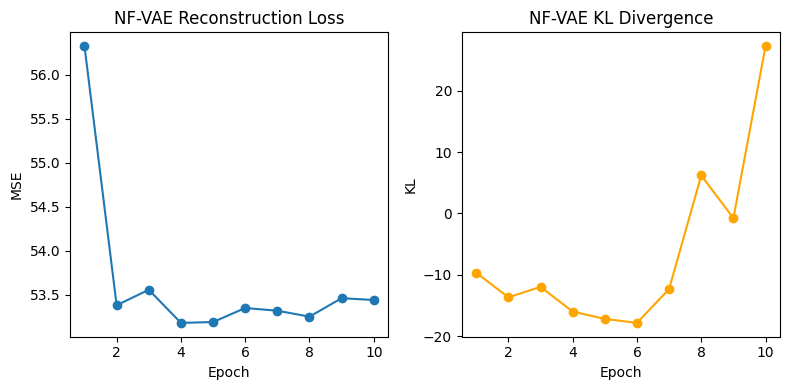

C:\Users\kemal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


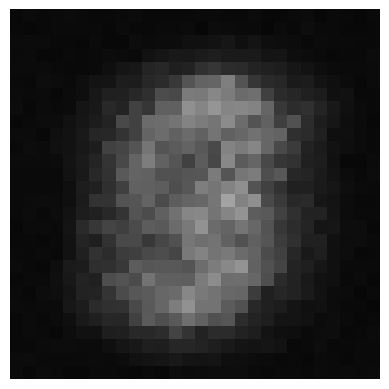

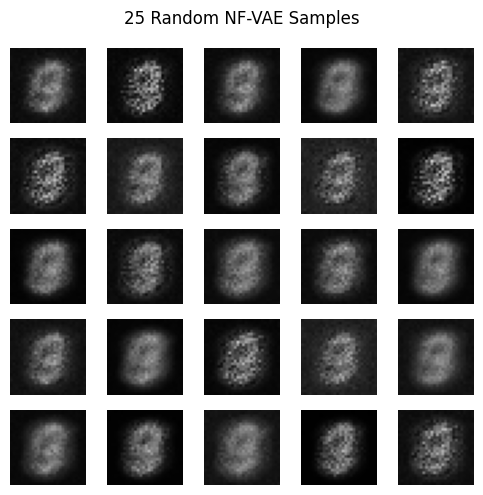

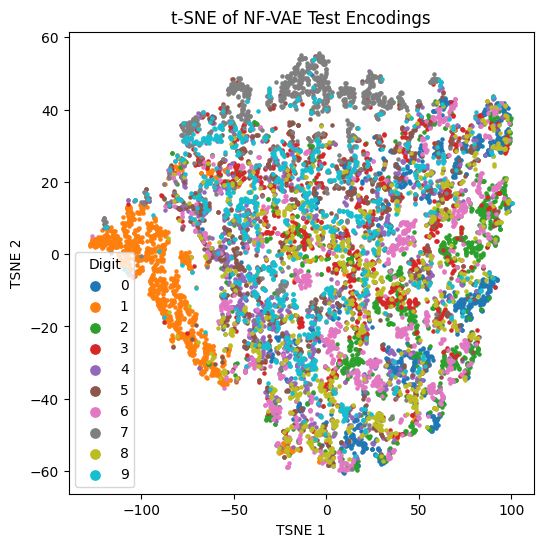

In [68]:
# --- 1) Plot training progress ---
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(range(1, EPOCHS+1), train_recon_losses, marker='o')
plt.title("NF-VAE Reconstruction Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")

plt.subplot(1,2,2)
plt.plot(range(1, EPOCHS+1), train_kls, marker='o', color='orange')
plt.title("NF-VAE KL Divergence")
plt.xlabel("Epoch")
plt.ylabel("KL")
plt.tight_layout()
plt.show()


# --- 2) Animation of one latent dimension traversal ---
z_base = torch.zeros(1, DIM_Z, device=DEVICE)
frames = []
for α in np.linspace(-3, 3, 60):
    z = z_base.clone()
    z[0, 0] = α
    with torch.no_grad():
        img = model.decoder(z).view(1, 28, 28).cpu().numpy()[0]
    frames.append(img)

fig = plt.figure()
im = plt.imshow(frames[0], cmap='gray', vmin=0, vmax=1)
plt.axis('off')

def update(i):
    im.set_data(frames[i])
    return (im,)

anim = animation.FuncAnimation(fig, update, frames=len(frames), interval=100)
plt.show()


# --- 3) 25 random samples from prior ---
with torch.no_grad():
    z_rand = torch.randn(25, DIM_Z, device=DEVICE)
    samples = model.decoder(z_rand).view(-1, 28, 28).cpu().numpy()

plt.figure(figsize=(5,5))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(samples[i], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
plt.suptitle("25 Random NF-VAE Samples")
plt.tight_layout()
plt.show()


# --- 4) t-SNE on encoded test set ---
model.eval()
all_mu = []
all_labels = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        mu, _ = model.encode(x.view(x.size(0), -1))
        all_mu.append(mu.cpu().numpy())
        all_labels.append(y.numpy())

all_mu    = np.concatenate(all_mu,    axis=0)
all_labels= np.concatenate(all_labels,axis=0)

tsne    = TSNE(n_components=2, random_state=42)
mu_2d   = tsne.fit_transform(all_mu)

plt.figure(figsize=(6,6))
for digit in range(10):
    idx = all_labels == digit
    plt.scatter(mu_2d[idx,0], mu_2d[idx,1], label=str(digit), s=5)
plt.legend(markerscale=3, title="Digit")
plt.title("t-SNE of NF-VAE Test Encodings")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.show()
